In [35]:
import pandas as pd
import os
#set the location
location = os.path.realpath(
    os.path.join(os.getcwd(), os.path.dirname('BUILDING_VIOLATIONS_After_2014.xlsx')))

For this challenge, you will be asked to answer questions regarding building violations from the city of Houston, TX. Each row in the data represents a single violation. You can download the dataset here.

In [3]:
file_path=os.path.join(location,'BUILDING_VIOLATIONS_After_2014.xlsx')
viol_data=pd.read_excel(file_path,sheet_name='Sheet1')

$(1)$How many building violations does the dataset contain?

In [67]:
tot_viol=len(viol_data)
print("(1). Total number of violations: "+str(tot_viol))

(1). Total number of violations: 376092


$(2)$ How many violations occurred in council district"D"?

In [37]:
print('(2). '+ str((viol_data.CouncilDistrict=='D').sum())+" violations reported in Council District D.")

(2). 12899 violations reported in Council District D.


In [38]:
#Get a more detailed look at the relevant data
#print("(2.1)Here is in detail how many violations happen in each Council District")
#viol_data['CouncilDistrict'].value_counts()

$(3)$How many of the violation's short descriptions mention "kitchen", "bathroom", or "toilet"? 

In [39]:
#The interesting words are
int_words='kitchen|bathroom|toilet'
#Let us now look closely how many descriptions contain these words
print('(3). '+str((viol_data['ShortDescription'].str.contains(int_words,case=False,na=False)).sum())+
      " short descriptions mention 'kitchen','bathroom' or 'toilet'.")

(3). 368 short descriptions mention 'kitchen','bathroom' or 'toilet'.


$(4)$What is the highest fraction of "OPEN" project status among the different violation categories?

In [40]:
#First let me clean up the data.
#Detailed look at data pointed a discrepency in how violation categories are name
# we homogenize these descriptions first.
viol_data['Violation_Category']=viol_data.Violation_Category.apply(lambda f: f[10:] if 'DON -' in f else f)
#Now we can simply find which category has the highest fraction of OPEN statuses
highest_open_frac=viol_data.groupby('Violation_Category').apply(lambda df:(df.Project_Status=='OPEN').sum()/df.Project_Status.count()).max()

In [41]:
#have a more detailed look at the fraction of open statuses for all different categories
cat_open_data=viol_data.groupby('Violation_Category').apply(lambda df:(df.Project_Status=='OPEN').sum()/df.Project_Status.count())
print('(4). Highest fraction of OPEN is '+ str(highest_open_frac)+ ' for the category ' + '"'+cat_open_data.idxmax()+'".')
#print('(4.1). A detailed look at the fraction of OPEN statuses in all violation categories')
#cat_open_data

(4). Highest fraction of OPEN is 0.2255964399027566 for the category "Dangerous Building".


$(5)$Calculate the average of the violations per capita for each ZIP code. The population for each ZIP code can be found here. Note, the ZIP code field in the violations dataset contains both 5 and 9 digit ZIP code formats. Truncate any 9 digit ZIP codes to just the standard 5 digit ZIP code. Further, the first two digits of Texas ZIP codes range from 75 to 79. Exclude records that do not fit this criteria of the 75-79 prefix. Do not consider any ZIP codes with a population less than 20,000.

In [42]:
#Okay. So now starts the non-trivial part
#Here is the strategy:
#1. CleanUp the postcode data.
#2. Compute violations for each postcode.
#3. Read and clean up population data
#4. Combine the two data to get per capita violations

In [43]:
#Let's do 1
viol_data['Zip']=viol_data['Zip'].str[:5]   
#Drop rows which are not numeric as well as NaN
num_Zip_data=(viol_data.drop(viol_data.loc[viol_data['Zip'].str.isnumeric()==False].index)).dropna(subset=["Zip"])
#population data has zip codes as 'int' type. let us convert the object type zip codes to int type here as well
num_Zip_data['Zip']=num_Zip_data['Zip'].astype(int)
#now drop zip codes outside Houston
num_Zip_data=num_Zip_data.drop(num_Zip_data.loc[num_Zip_data.Zip.apply(lambda x: x<75000 or x>79999)].index)

In [44]:
#2,now calculate total number of violations per zip code and create a dataframe
viol_Zip_data=num_Zip_data['Zip'].value_counts().to_frame().reset_index().rename(columns={'index':'Zip','Zip':'TotalViolations'})

In [45]:
#3,Let's deal with population now
pop_file_path=os.path.join(location,"houston_population_by_ZIP_code.csv")
pop_data=pd.read_csv(pop_file_path)

In [46]:
#Rename the Zip code column
pop_data=pop_data.rename(columns={'Zip Code':'Zip'})
#Drope the data with population less than 20000
pop_data_g20k=pop_data.drop(pop_data.loc[pop_data['Population']<20000].index)

In [47]:
#4.Merge the total violations data with the population data
Zip_pop_data=pop_data_g20k.merge(viol_Zip_data,how='left',left_on='Zip',right_on='Zip')

In [48]:
#Add a new column with violations per capita
Zip_pop_data['Violations Per Capita']=Zip_pop_data['TotalViolations']/Zip_pop_data['Population']

In [49]:
#Finally compute the average
print('(5). Average of violations per capita over all zip codes is '+
      str((Zip_pop_data.dropna())['Violations Per Capita'].mean())+'.')

(5). Average of violations per capita over all zip codes is 0.15507254386483685.


$(6)$ Calculate the conditional probability of each violation category occuring given that it occured in a given council district. What is the median of these conditional probability? Do not consider violation category / council district pairs that had less than 50 counts.

In [50]:
#first need to clean up data further
#start by dropping NaN etc. in CouncilDistrict
Dist_Cat_data=((viol_data.dropna(subset=['CouncilDistrict']))).copy()
#Capitalize all occurences in CouncilDistrict so that we don't have to worry about 'b' and 'B' etc. 
Dist_Cat_data['CouncilDistrict']=Dist_Cat_data['CouncilDistrict'].str.upper()

In [51]:
#Now let us focus on the relvant data and see how many times each District and Category pair occur
Dist_Cat_tot_data=Dist_Cat_data.groupby(['CouncilDistrict','Violation_Category']).size().reset_index(name="TotalViolations")

In [52]:
#drop violations with less than 50 
dist_cat_geq50=Dist_Cat_tot_data.drop(Dist_Cat_tot_data.loc[Dist_Cat_tot_data['TotalViolations']<50].index)

In [53]:
#a column with total number of violations
tot_dist_viol=pd.DataFrame(list(zip([dist_cat_geq50.loc[dist_cat_geq50['CouncilDistrict']==cdis].
 TotalViolations.sum(0) for cdis in dist_cat_geq50.CouncilDistrict.unique()]
                      ,dist_cat_geq50.CouncilDistrict.unique())))
tot_dist_viol.columns=['TotViolDistrict','CouncilDistrict']

In [54]:
#merge the column with the rest of the data
dist_cat_geq50=dist_cat_geq50.merge(tot_dist_viol,how='left',left_on='CouncilDistrict',right_on='CouncilDistrict')

In [55]:
#calculate conditional probabilities
dist_cat_geq50['Cond_Prob']=dist_cat_geq50['TotalViolations']/dist_cat_geq50['TotViolDistrict']

In [56]:
#Compute the median now
print('(6). Median of conditional probabilities is ' + str(dist_cat_geq50['Cond_Prob'].median())+'.')

(6). Median of conditional probabilities is 0.1423986838751535.


($7$)
How big is Houston in terms of square miles? We can estimate the area by using the latitude and longitude of each of Houston's ZIP codes. These coordinates are in the population by ZIP code dataset. For each ZIP code, determine the distance to each ZIP code. With all of these distances, estimate the radius by usig this formula:

radius=${45\pi\over 128}\overline{D}$,

where $\overline{D}$is the average of all the calculated distances. Take the estimated radius and calculate the square miles of a circle with this radius. For calculating distances, please use the spherical Earth projected to a plane equation. Use the radius of the Earth as 6371 km. For conversion between kilometers and miles, use that one mile is equal to 1.60934 kilometers.

In [57]:
#Next question. This is about Houston's area. 
#Idea is to use the longitude and latitude information to compute the area using the standard formula
#probably a good idea to define a function which computes these distances
import math 
def dist_compute(coord1,coord2):
    coord1=[float(x) for x in coord1.split(',')]
    coord2=[float(x) for x in coord2.split(',')]
    return((6371/1.60934)*(math.pi/180)*math.sqrt( (coord1[0]-coord2[0])**2+(math.cos((math.pi/180)*(coord1[0]/2+coord2[0]/2))*(coord1[1]-coord2[1]))**2))

In [58]:
#average_distance of each zip code
av_each_zip=pd.DataFrame([pop_data.Location.apply(lambda x: dist_compute(x,y)).mean() for y in pop_data.Location],columns=['Av_Dist_miles'])

In [59]:
area_Houston=math.pi*((45*math.pi/128)**2)*(av_each_zip.Av_Dist_miles.mean())**2

In [60]:
print('(7). Area of Houston is approximately '+str(round(area_Houston))+' square miles.')

(7). Area of Houston is approximately 728 square miles.


($8$)
Apart from when the record was created, the dataset contains two other columns with date information. It contains the date of the deadline to correct the violation and the date when a checkback is schedule to be performed. The difference between the checkback and deadline date has been dropping with time. For violations between 2014 and 2016 (inclusive), first determine the average number of days between the checkback and deadline date for each month. If you visualize this result, you should see a linear decline with each month. Afterwards, use a linear estimate to determine how the number of days between checkback and deadline drops between each month.

In [61]:
#The sixth question now
#Drop rows with missing values and convert strings to dates
viol_dates_data=(viol_data[['RecordCreateDate','DeadLineDate','CheckBackDate']].dropna()).apply(pd.to_datetime)
#drop before 2014 and after 2016
viol_dates_data=viol_dates_data.drop(viol_dates_data.loc[viol_dates_data.RecordCreateDate.apply(lambda x: x<pd.to_datetime('2014') or x>pd.to_datetime('2016'))].index)
#drop the day from record create date
viol_dates_data['RecordCreateDate']=viol_dates_data['RecordCreateDate'].apply(lambda x:x.strftime('%Y-%m'))
#Add a new columns with number of days between checkback date and deadline date
viol_dates_data['Days_bw_Check_and_DeadLine']=pd.to_numeric((viol_dates_data['CheckBackDate']-viol_dates_data['DeadLineDate']).dt.days)

In [62]:
#compute the average number of days between the checkback and deadline date for each month
viol_date_days_data=viol_dates_data[['RecordCreateDate','Days_bw_Check_and_DeadLine']].groupby('RecordCreateDate').mean().reset_index()
#print('(8.supplementary). The average number of days between the checkback and deadline date look something like this:')
#viol_date_days_data

In [63]:
#Visualize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<AxesSubplot:title={'center':'Visualizing how days between check back and the deadline drop'}, xlabel='Number of months from January 2014', ylabel='days b/w the Check back and the Deadline'>

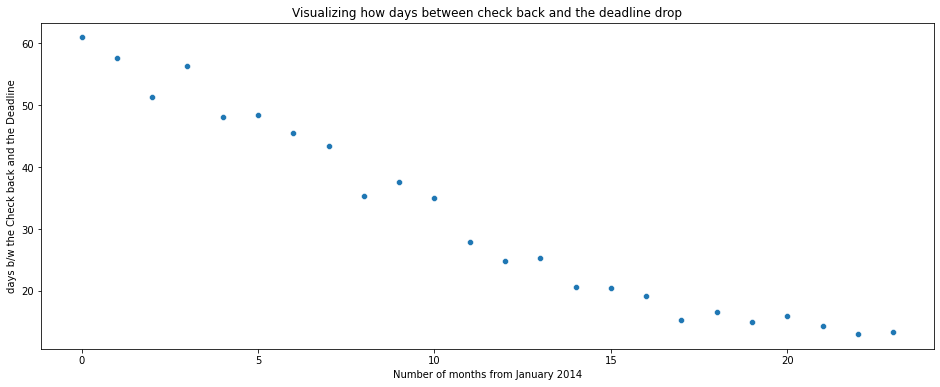

In [64]:
plt.figure(figsize=(16,6))
plt.xlabel('Number of months from January 2014')
plt.ylabel('days b/w the Check back and the Deadline')
plt.title('Visualizing how days between check back and the deadline drop')
sns.scatterplot(x=viol_date_days_data.index,y=viol_date_days_data['Days_bw_Check_and_DeadLine'])

In [65]:
#Using a linear estimation
import numpy as np
from sklearn.linear_model import LinearRegression
x=viol_date_days_data.index.to_numpy().reshape((-1,1))
y=viol_date_days_data['Days_bw_Check_and_DeadLine'].to_numpy()

In [66]:
model=LinearRegression()
model.fit(x,y)
how_day_drop=model.coef_[0]
print('(8). Number of days are dropping by ' +str(-how_day_drop)+ ' days per month.')

(8). Number of days are dropping by 2.216481385102851 days per month.
